In [1]:
# library
import pandas as pd
import os 
import feather
import numpy as np
import statsmodels
import statsmodels.api as sm
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARMA
from statsmodels.tsa.arima_model import ARMAResults
import matplotlib.pyplot as plt
from scipy.stats import norm, uniform, pearsonr

In [2]:
# read in 
WU = feather.read_dataframe('WU.feather')

In [3]:
col_names = ['Index', 'TotalWaterUse', 'year', 'month', 'monthIndex',
       'E_Label_ParcelID', 'X_Coord_of_Centroid', 'Y_Coord_ofCentroid',
       'ParcelID', 'AW_percent_month_mean', 'GIR1_month_mean',
       'RAW2_month_mean', 'P_month_mean', 'ET_turf_month_mean', 'XF_AREA',
       'GreenSpace_Est', 'BldVal', 'LndVal', 'Days', 'Shape_Area',
       'E_yearEffmin', 'E_yearActmin', 'E_HeatGrsAreaRatio_Parcel',
       'E_HeatGrsAreaDiff_Parcel', 'E_Parcel_FPE_ALL_Ratio', 'E_freq_pixel',
       'E_Parcel_FPE_XF', 'Set']

In [4]:
# read in AR1 pars
ar1pars = feather.read_dataframe('AR1_pars.feather')

# sim

In [5]:
# setup
np.random.seed(8)
parcels = WU.E_Label_ParcelID.unique()
# subsample
subsample_size = 100
parcels = np.random.choice(parcels,subsample_size, replace=False)
n_parcels = len(parcels)

# set pars
forecast_steps = 12
# phi = np.random.uniform(0.7,0.95, n_parcels)

rhos = ar1pars['Rho'].values
intcpts = ar1pars['Intercepts'].values
sds = ar1pars['sd'].values

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
np.random.seed(8)
alpha = 0.05

for i, prcl in enumerate(parcels):
    # sim data
    rho = rhos[prcl-1]
    intcpt = intcpts[prcl-1]
    sd = sds[prcl-1]
    
    nsample = WU[WU['E_Label_ParcelID'] == prcl].shape[0] - forecast_steps + 0
    
    ar1 = np.array([1, -rho])
    ma1 = np.array([1])
    
    AR_object1 = ArmaProcess(ar1, ma1)
    simulated_data_0 = AR_object1.generate_sample(nsample=nsample+forecast_steps)*sd  + intcpt
    simulated_data_1 = simulated_data_0[:-forecast_steps]
    
    # truth
    y_true =  simulated_data_0[-forecast_steps:]
    
    # 12-month
    ## fit model & forecast
    mod = ARMA(simulated_data_1, order=(1, 0))
    res = mod.fit()
    preds, _, ci = res.forecast(forecast_steps, alpha=alpha)
    
    t12_fit = np.concatenate([y_true.reshape(-1,1), preds.reshape(-1,1), ci],1)
    
    ## true model & forecast
    armar = ARMAResults(mod, params=np.array([1, rho]))
    preds, _, ci = armar.forecast(steps=forecast_steps, exog=None, alpha=alpha)
    
    t12_true = np.concatenate([y_true.reshape(-1,1), preds.reshape(-1,1), ci],1)
    
    # 1-month
    for j in range(forecast_steps):
        
        Y_train = simulated_data_0[:j-forecast_steps] # updated train
        
        ## fit model & forecast
        mod = ARMA(Y_train, order=(1, 0))
        res = mod.fit()
        preds, _, ci = res.forecast(1, alpha=alpha)
    
        t1_fit_j = np.concatenate([y_true[j].reshape(-1,1), preds.reshape(-1,1), ci],1)

        ## true model & forecast
        armar = ARMAResults(mod, params=np.array([1, rho]))
        preds, _, ci = armar.forecast(steps=1, exog=None, alpha=alpha)
        preds = preds*sd  + intcpt
        ci = ci*sd  + intcpt
        
        t1_true_j = np.concatenate([y_true[j].reshape(-1,1), preds.reshape(-1,1), ci],1)
        
        # stack
        if j == 0:
            t1_fit = t1_fit_j
            t1_true = t1_true_j
        else:
            t1_fit = np.concatenate([t1_fit,t1_fit_j],0)
            t1_true = np.concatenate([t1_true,t1_fit_j],0)
    
    # stack over all parcels
    if i == 0:
        Yvar = simulated_data_0
        test_results_12_t = t12_true
        test_results_1_t = t1_true
        test_results_12_f = t12_fit
        test_results_1_f = t1_fit
        
    else:
        Yvar = np.concatenate([Yvar,simulated_data_0])
        test_results_12_t = np.concatenate([test_results_12_t,t12_true], 0)
        test_results_1_t = np.concatenate([test_results_1_t,t1_true], 0)
        test_results_12_f = np.concatenate([test_results_12_f,t12_fit], 0)
        test_results_1_f = np.concatenate([test_results_1_f,t1_fit], 0)
    
        
print('done')   

done


In [8]:
WU[(WU['E_Label_ParcelID'] == prcl) & (WU["Set"] != 'test')].shape

(125, 21)

(array([2.000e+00, 2.400e+01, 1.030e+02, 1.404e+03, 5.260e+03, 4.533e+03,
        1.839e+03, 4.370e+02, 8.100e+01, 1.700e+01]),
 array([-10627.60038646,  -7592.11575665,  -4556.63112685,  -1521.14649704,
          1514.33813277,   4549.82276258,   7585.30739238,  10620.79202219,
         13656.276652  ,  16691.7612818 ,  19727.24591161]),
 <BarContainer object of 10 artists>)

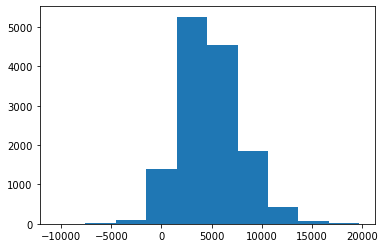

In [9]:
# visualize simulated data
plt.hist(Yvar) # blue is water

# construct pd

In [10]:
WUsim = WU[WU['E_Label_ParcelID'].isin(parcels)]
WUsim.loc[:,"TotalWaterUse"] = Yvar
# WUsim.loc[:,"ET_turf_month_mean"] = Yvar[:,1]

In [11]:
WUsim.columns

Index(['Index', 'TotalWaterUse', 'year', 'month', 'monthIndex',
       'E_Label_ParcelID', 'X_Coord_of_Centroid', 'Y_Coord_ofCentroid',
       'ParcelID', 'AW_percent_month_mean', 'GIR1_month_mean',
       'RAW2_month_mean', 'P_month_mean', 'ET_turf_month_mean', 'XF_AREA',
       'GreenSpace_Est', 'BldVal', 'LndVal', 'Days', 'Shape_Area', 'Set'],
      dtype='object')

In [12]:
# sim X irrelevant or slightly relavent  
np.random.seed(1)
ar = []
none_sim_list = ['Index','year','ParcelID','Days','year','month',
                 'TotalWaterUse', 'monthIndex', 
                 'X_Coord_of_Centroid', 'Y_Coord_ofCentroid',
                 'Set','E_Label_ParcelID']
for i,f in enumerate(WUsim.columns):
    if f in none_sim_list:
        continue
    
    n = WUsim.shape[0]
    sig = 2
    rvs = uniform.rvs(-i,i*2,n)
    rvs_perb = uniform.rvs(loc=rvs-sig,scale=2*sig,size=n)
    WUsim.iloc[:,i] = rvs
    # parcel level
    ar.append(rvs_perb) # counts for w uncertainty used to compute y
    print(i,f)

9 AW_percent_month_mean
10 GIR1_month_mean
11 RAW2_month_mean
12 P_month_mean
13 ET_turf_month_mean
14 XF_AREA
15 GreenSpace_Est
16 BldVal
17 LndVal
19 Shape_Area


In [13]:
# done 
WUsim

,Index,TotalWaterUse,year,month,monthIndex,E_Label_ParcelID,X_Coord_of_Centroid,Y_Coord_ofCentroid,ParcelID,AW_percent_month_mean,...,RAW2_month_mean,P_month_mean,ET_turf_month_mean,XF_AREA,GreenSpace_Est,BldVal,LndVal,Days,Shape_Area,Set
0,1,1923.522423,1998,9,9.0,1,473588.7674,1338172.346,172825090000075000670U,-1.493604,...,0.729787,4.362512,9.739420,10.806552,1.902543,-2.851143,-15.104135,30,0.973613,train
1,2,2360.260505,1998,10,10.0,1,473588.7674,1338172.346,172825090000075000670U,3.965841,...,8.357321,-10.062394,8.248308,-6.307376,-4.443781,-3.521281,10.438918,31,-12.873064,train
2,3,1522.083319,1998,11,11.0,1,473588.7674,1338172.346,172825090000075000670U,-8.997941,...,3.215651,-11.648748,-1.148727,-5.079097,7.195283,5.408309,8.744050,30,5.335722,train
3,4,1002.018656,1998,12,12.0,1,473588.7674,1338172.346,172825090000075000670U,-3.558014,...,4.531858,-11.560929,5.285652,-10.484326,9.875196,11.042593,-5.061846,31,15.829345,train
4,5,171.233093,1999,1,13.0,1,473588.7674,1338172.346,172825090000075000670U,-6.358394,...,0.939318,-6.500128,10.246537,-9.123167,-0.445114,-14.607939,-4.000439,31,-10.929742,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13695,133160,1998.552739,2009,9,141.0,972,533602.4000,1312373.000,1929231OV000000000260U,-6.604142,...,8.069954,8.156950,0.792440,8.931585,-3.876817,-10.285419,-8.471977,30,-16.609064,test
13696,133161,5293.211397,2009,10,142.0,972,533602.4000,1312373.000,1929231OV000000000260U,-1.972850,...,6.788131,5.538798,-4.700061,-2.522445,1.959976,-11.425383,-6.146393,31,3.440117,test
13697,133162,4962.914333,2009,11,143.0,972,533602.4000,1312373.000,1929231OV000000000260U,7.108843,...,-1.203478,-4.030085,-6.466886,7.392855,-14.344517,-11.547662,7.393908,30,-0.019858,test
13698,133163,7624.261630,2009,12,144.0,972,533602.4000,1312373.000,1929231OV000000000260U,2.805821,...,-9.423126,2.313275,1.083400,9.280016,5.062869,-7.010148,-12.653040,31,-6.359678,test


In [14]:
# write sim data
path = 'WU.feather' # modify
feather.write_dataframe(WUsim, path)

In [15]:
# write best result
np.save('test_results_1_f',test_results_1_f)
np.save('test_results_12_f',test_results_12_f)

In [27]:
import progressbar
from time import sleep
def add_group_lags(data,
                   group, # a feature string or a list of feature string
                   timeindex, # a string indicating time index
                   features, # a list of string for generating lags
                   other, # a list of other feature strings or None
                   nlag, # number of lags
                   fillna = None
                  ):
    

    for i, d in enumerate(data.groupby(group)):
        n,g=d
        maxt = g.loc[:,timeindex].max()
        mint = g.loc[:,timeindex].min()
        #maxl = maxt-mint+1
        npd = pd.DataFrame({
            group: n,
            timeindex:(np.arange(mint, maxt+1)).astype('int32')
        })
        if(i == 0):
            out = npd
        else:
            out = pd.concat([out,npd],axis=0)
    
    if other == None:
        selectp = [group,timeindex]+features
    else:
        selectp = [group,timeindex]+other+features
    dfull = pd.merge(out,data.loc[:,selectp],on=[group,timeindex],how='left')
    
    print('Time range extension done!')
    
    ngrp = data[group]
    
    bar = progressbar.ProgressBar(maxval=len(data[group].unique())+10,
                                  widgets=[progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
    
    bar.start()  
    
    for i, d in enumerate(dfull.groupby(group)):
        
        n,g0=d
        g = g0
        fn = g0.loc[:,features].columns
        
        for lag in np.arange(1,nlag+1):
            
            glag = g0.loc[:,features].shift(lag)
            glag.columns = fn +'_lag%s'%(lag)
            g = pd.concat([g,glag], axis=1)
        
        
        if(i == 0):
            out2 = g
        else:
            out2 = pd.concat([out2,g],axis=0)
        # we update bar 
        bar.update(i+1) 
        sleep(0.1)
        
    bar.finish()
                  
    if fillna != None:
        out2 = out2.fillna(fillna)     
    
    return out2


In [31]:
WULags =  add_group_lags(WUsim,"ParcelID","monthIndex",  ["TotalWaterUse"], None, 5,  fillna = None)

Time range extension done!


[========================================================================] 100%


In [32]:
WUsim2 = pd.concat([WUsim.drop(columns=["ParcelID","monthIndex","TotalWaterUse"]),WULags],axis=1)

In [8]:
# write sim data
path = 'WU_lag.feather' # modify
feather.write_dataframe(WUsim2.dropna(), path)